## This notebook contains solutions to exercises 1, 2, 3, 10, 12 in Data analysis recipies: Fitting a model to data by David Hogg, Jo Bovy, and Dustin Lang.

In [117]:
# general imports for all coming exercises
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from functools import partial

# Types
from typing import TypeAlias, Callable
Matrix: TypeAlias = np.ndarray
Vector: TypeAlias = np.ndarray
Function: TypeAlias = Callable[[Vector], Vector]

# Exercise 1: 
Use the standard linear algebra from Section 1. to fit the straight line $y = mx + b$ to the $x$, $y$, and $sigma_y$ values provided in the file `hogg-table1.txt`. We ignore the first four data points in the table.

In [155]:

TABLE_FILE = Path("hogg-table1.txt")
table = np.loadtxt(TABLE_FILE, usecols=(1, 2, 3, 4, 5), unpack=True)


We start by arranging the data in the table in to the vectors/matrices:
\begin{align*}
    \boldsymbol{Y} &= \begin{bmatrix}
        y_1 \\
        y_2 \\
        \dots \\ 
        y_N
    \end{bmatrix}, \\
    \boldsymbol{A} &= \begin{bmatrix}
        1 & x_1 \\
        1 & x_2 \\
    \dots & \dots\\ 
        1 & x_N
    \end{bmatrix}, \\
        \boldsymbol{C} &= \begin{bmatrix}
        \sigma^2_{y_1} & 0 & \dots & 0 \\
        0 &  \sigma^2_{y_2} & \dots & 0 \\
        \dots & \dots & \dots & \dots & \\
        0 & 0 & \dots & \sigma^2_{y_N} \\
    \end{bmatrix}
\end{align*}

In [157]:
x, y, sigma_y = table[:, 5:][:3] # columns for x, y, and sigma_y

A = np.vstack([np.ones(len(x)), x]).T
C = np.diag(sigma_y**2)
Y = y

We can then solve the normal equations:

\begin{align*}
    \begin{bmatrix}
        b \\ m
    \end{bmatrix}
     = \boldsymbol{X} = \left[ \boldsymbol{A}^{\mathrm{T}}  \boldsymbol{C}^{\mathrm{-1}} \boldsymbol{A} \right]^{-1} \left[ \boldsymbol{A}^{\mathrm{T}}  \boldsymbol{C}^{\mathrm{-1}} \boldsymbol{Y} \right]
\end{align*}

In [120]:
def solve_normal_equations(A: Matrix, C: Matrix, Y: Vector) -> Vector:
    """Solves the equation X = [A^T C^{-1} A]^{-1} [A^T C^{-1} Y]."""
    C_inv = np.linalg.inv(C)
    sigma_inv = np.linalg.inv(A.T @ C_inv @ A)
    return sigma_inv @ (A.T @ C_inv @ Y)
    

In [121]:
b, m = solve_normal_equations(A, C, Y)
b, m

(34.845941313398725, 2.2325362169534166)

To get the uncertianties $\sigma_b$ and $\sigma_m$ we need to take the diagonal of the covariance matrix 
\begin{equation*}
\begin{bmatrix}
\sigma_b \\ 
\sigma_m
\end{bmatrix} = \mathrm{diag}\left( 
    \begin{bmatrix}
    \sigma_b^2 & \sigma_{mb}\\
    \sigma_{mb} & \sigma_m^2
    \end{bmatrix}
 \right)
\end{equation*},
where
\begin{equation*}
    \begin{bmatrix}
    \sigma_b^2 & \sigma_{mb}\\
    \sigma_{mb} & \sigma_m^2
    \end{bmatrix} = 
    \left[ \boldsymbol{A}^{\mathrm{T}}  \boldsymbol{C}^{\mathrm{-1}} \boldsymbol{A} \right]^{-1}
\end{equation*}
is the covariance matrix

In [122]:
def get_sigma_X(A: Matrix, C: Matrix) -> Vector:
    """Computes the uncertianty of the variables fit."""
    C_inv = np.linalg.inv(C)
    sigma_inv = np.linalg.inv(A.T @ C_inv @ A)
    return np.sqrt(sigma_inv.diagonal())

In [123]:
sigma_b, sigma_m = get_sigma_X(A, C)
sigma_b, sigma_m

(18.42264040708828, 0.11031991507180255)

We plot the data and the best fit line $y = mx + b$ along with the uncertianties in $m$ and $b$:

In [124]:
def evaluate_linear_model(x: Vector, b: float, m: float) -> Vector:
    """Evaluate the linear model in excercise 1."""
    return m * x + b

Text(0, 0.5, '$y$')

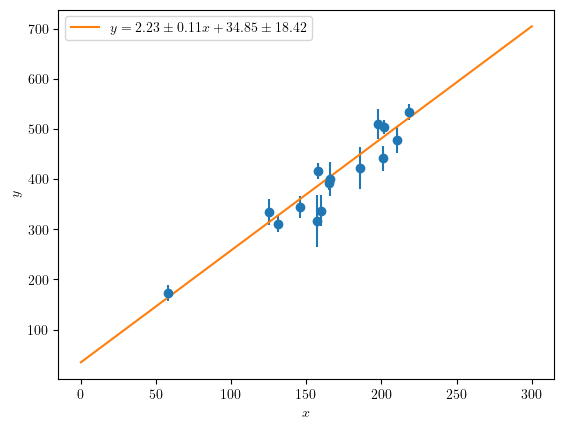

In [125]:
x_new = np.linspace(0, 300, 20) 
y_hat = evaluate_linear_model(x_new, b, m)

plt.errorbar(x, y, yerr=sigma_y, fmt="o")
plt.plot(x_new, y_hat, label=rf"$y = {{{m:.2f}}} \pm {{{sigma_m:.2f}}}x + {b:.2f} \pm {{{sigma_b:.2f}}}$")
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$y$")

## Exercise 2:

We repeat the above calculating but for all the data points in the original table

In [126]:
x, y, sigma_y = table[:3]
A = np.vstack([np.ones(len(x)), x]).T
C = np.diag(sigma_y**2)
Y = y

b, m = solve_normal_equations(A, C, Y)
b, m

(213.2734919759614, 1.0767475241683258)

In [127]:
sigma_b, sigma_m = get_sigma_X(A, C)
sigma_b, sigma_m

(14.39403310716221, 0.0774067831657561)

Text(0, 0.5, '$y$')

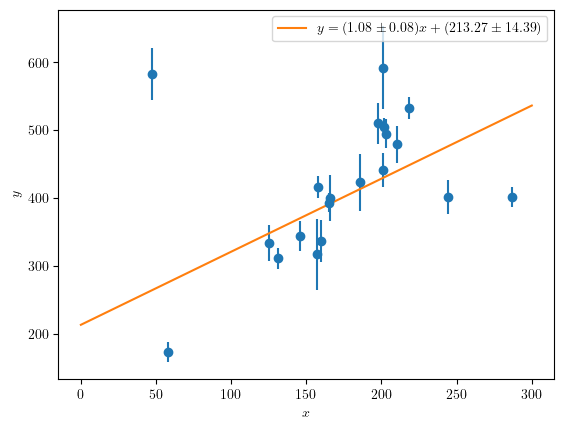

In [128]:
x_new = np.linspace(0, 300, 20) 
y_hat = evaluate_linear_model(x_new, b, m)

plt.errorbar(x, y, yerr=sigma_y, fmt="o")
plt.plot(x_new, y_hat, label=rf"$y = ({{{m:.2f}}} \pm {{{sigma_m:.2f}}})x + ({b:.2f} \pm {{{sigma_b:.2f}}})$")
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$y$")

The new data points are some pretty big outliers which result in half as big of a slope. 

## Exercise 3:
We will now repeat the fit in exercise one but with a quadratic equation on the form $g(x) = q x^2 + m x + b$

In [129]:
def evaluate_quadratic_model(x: Vector, q: float, m: float, b: float) -> Vector:
    """Evaluate the quadratic model in exercise 3."""
    return q * x**2 + m * x + b

We can solve for $q$, $m$, and $b$ using the same method as before by adding another column to the matrix $\boldsymbol{A}$ which contains the $x^2$ values:

\begin{align}
    \boldsymbol{A} &= \begin{bmatrix}
        1 & x_1 & x_1^2 \\
        1 & x_2 & x_2^2 \\
         & \dots &  \\ 
        1 & x_N & x_N^2
    \end{bmatrix}. \\
\end{align}

Solving the normal equations now give us an additional fit for $q$:

\begin{align*}
    \begin{bmatrix}
        b \\ m \\ q
    \end{bmatrix}
     = \boldsymbol{X} = \left[ \boldsymbol{A}^{\mathrm{T}}  \boldsymbol{C}^{\mathrm{-1}} \boldsymbol{A} \right]^{-1} \left[ \boldsymbol{A}^{\mathrm{T}}  \boldsymbol{C}^{\mathrm{-1}} \boldsymbol{Y} \right]
\end{align*}

In [130]:
x, y, sigma_y = table[:, 5:][0:3]
A = np.vstack([np.ones(len(x)), x, x**2]).T
C = np.diag(sigma_y**2)
Y = y

b, m, q = solve_normal_equations(A, C, Y)
b, m, q

(72.57649611682064, 1.6045304764425055, 0.002254145076158398)

We then get the uncertianties like earlier:

In [131]:
sigma_b, sigma_m, sigma_q = get_sigma_X(A, C)
sigma_b, sigma_m, sigma_q

(38.956134622701214, 0.5818712155922691, 0.002050669814280644)

Text(0, 0.5, '$y$')

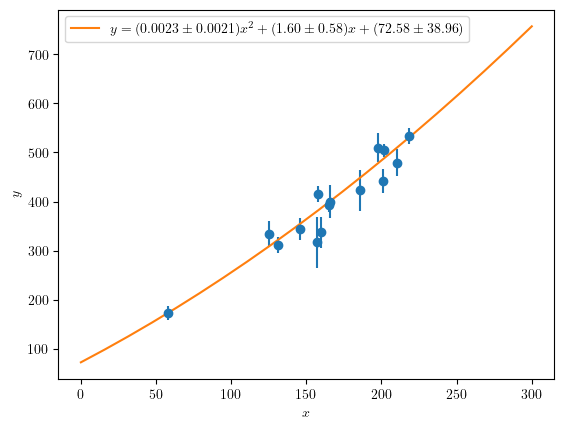

In [132]:
x_new = np.linspace(0, 300, 20) 
y_hat = evaluate_quadratic_model(x_new, q, m, b)

plt.errorbar(x, y, yerr=sigma_y, fmt="o")
plt.plot(x_new, y_hat, label=rf"$y = ({{{q:.4f}}} \pm {{{sigma_q:.4f}}})x^2 + ({{{m:.2f}}} \pm {{{sigma_m:.2f}}})x + ({b:.2f} \pm {{{sigma_b:.2f}}})$")
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$y$")

## Exercise 10:
We want to compute the $\chi^2$, the total error squared scaled by the uncertianties, of the model in exercise 1. The chi^2 is given by
\begin{equation*}
    \chi^2 = \sum^N_{i=1} \frac{\left[ y_i - f(x_i) \right]^2}{\sigma^2_{y_i}}
\end{equation*},
which in linear algebra notation is
\begin{equation*}
\chi^2 \equiv \left[ \boldsymbol{Y} - \boldsymbol{A}\boldsymbol{X} \right]^T \boldsymbol{C}^{-1} \left[ \boldsymbol{Y} - \boldsymbol{A}\boldsymbol{X} \right]
\end{equation*}.

Below we implement the two definitions of the $\chi^2$:

In [133]:
def get_chi_squared(y: Vector, fn: Function, x: Vector, sigma_y: Vector) -> float:
    """Computes the chi squared value."""
    return np.sum((y - fn(x))**2 / sigma_y**2)

def get_chi_squared_linalg(A: Matrix, C: Matrix, Y: Vector, X: Vector) -> float:
    """Computes the chi squared value in matrix notation."""
    return (Y - A @ X).T @ np.linalg.inv(C) @ (Y - A @ X)

We make sure they return the same $\chi^2$ for the same model ($f(x)$ or $\boldsymbol{A}\boldsymbol{X}$):

In [137]:
x, y, sigma_y = table[:, 5:][0:3] # columns for x, y, and sigma_y as before in excerise 1

A = np.vstack([np.ones(len(x)), x]).T
C = np.diag(sigma_y**2)
Y = y
b, m = solve_normal_equations(A, C, Y)

eval_model_ex1 = partial(evaluate_linear_model, b=b, m=m) # make a partial function with the fitted parameters for the linear model

chisq1 = get_chi_squared(y, eval_model_ex1, x, sigma_y)
chisq2 = get_chi_squared_linalg(A, C, Y, [b, m])
chisq1, chisq2

(18.582309526605396, 18.582309526605393)

We now do the same $\chi^2$ evaluation but for the model in exercise 2 where we have included the *bad* data points:

In [170]:
x, y, sigma_y = table[0:3] # columns for x, y, and sigma_y as before in excerise 1

A = np.vstack([np.ones(len(x)), x]).T
C = np.diag(sigma_y**2)
Y = y
b, m = solve_normal_equations(A, C, Y)

eval_model_ex1 = partial(evaluate_linear_model, b=b, m=m) # make a partial function with the fitted parameters for the linear model

chisq1 = get_chi_squared(y, eval_model_ex1, x, sigma_y)
chisq2 = get_chi_squared_linalg(A, C, Y, [b, m])
chisq1, chisq2

(20, 20)


(289.9637227819993, 289.9637227819993)

The $\chi^2$ in the second exercise is much larger than the one in exercise 1 as was expected from the inclusion of the data points that didnt appear to fit the linear model. 

## Exercise 13:
What happens if we now include the uncertianties to the $x$ positions, $\sigma_x$?

In [194]:
x, y, sigma_y, sigma_x = table[:, 5:][:4]




